<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

In [ ]:
!nvidia-smi

Sat Oct 15 10:49:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |    826MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.9.2


In [ ]:
# !pip install -q tensorflow==2.8.2

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 35.80 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 10.4 MB 28.1 MB/s 
     |████████████████████████████████| 211 kB 69.3 MB/s 
     |████████████████████████████████| 281 kB 65.5 MB/s 
     |████████████████████████████████| 99 kB 2.1 MB/s 
     |████████████████████████████████| 238 kB 61.6 MB/s 
     |████████████████████████████████| 4.7 MB 60.6 MB/s 
     |████████████████████████████████| 1.1 MB 64.9 MB/s 
     |████████████████████████████████| 352 kB 76.9 MB/s 
     |████████████████████████████████| 1.3 MB 67.2 MB/s 
     |████████████████████████████████| 11.2 MB 49.0 MB/s 
     |████████████████████████████████| 3.1 MB 39.6 MB/s 
     |████████████████████████████████| 408 kB 61.0 MB/s 
     |████████████████████████████████| 185 kB 54.8 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 960 kB 72.5 MB/s 
     |████████████████████████████████| 1.0 MB 64.5 MB/s 
     |████████████

# Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression= 'zip', low_memory= False)

In [ ]:
df.shape

(1306122, 3)

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

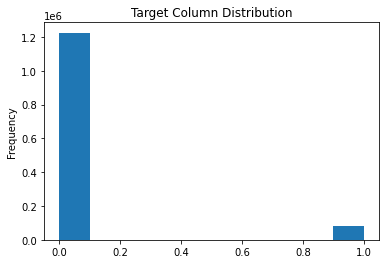

In [71]:
df.target.plot(kind = 'hist', title = 'Target Column Distribution')

##Create tf.data.Datasets for Training and Evaluation

In [ ]:
train_df, remain_df = train_test_split(df, random_state = 0, train_size= 0.0075, stratify= df.target.values)
valid_df, _ = train_test_split(remain_df, random_state= 0, train_size= 0.00075, stratify= remain_df.target.values)

In [ ]:
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))

##Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable= True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = tokenization.FullTokenizer(vocab_file, lower_case)

##Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid= None, text_a= text.numpy(), text_b= None, label= label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  

##Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature,
                                                                inp= [text, label], 
                                                                Tout= [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {'input_word_ids' : input_ids,
       'input_mask': input_mask,
       'input_type_ids' : segment_ids}

  return (x, label_id)

##Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls= tf.data.experimental.AUTOTUNE).shuffle(1000).batch(32, drop_remainder= True).prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls= tf.data.experimental.AUTOTUNE).batch(32, drop_remainder= True).prefetch(tf.data.experimental.AUTOTUNE)) 

  
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

##Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
from tensorflow.python.ops.ragged.row_partition import segment_id_ops
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape= (max_seq_length,), dtype= tf.int32,
                                         name= 'input_word_ids')
  input_mask = tf.keras.layers.Input(shape= (max_seq_length,), dtype= tf.int32,
                                         name= 'input_mask')
  input_type_ids = tf.keras.layers.Input(shape= (max_seq_length,), dtype= tf.int32,
                                         name= 'input_type_ids')
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop_out = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation= 'sigmoid', name= 'output')(drop_out)

  model = tf.keras.Model(
      inputs= {'input_word_ids' : input_word_ids,
       'input_mask': input_mask,
       'input_type_ids' : input_type_ids},
       outputs = output
  )
  return model

##Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 2e-5), 
              loss= tf.keras.losses.BinaryCrossentropy(), 
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',       

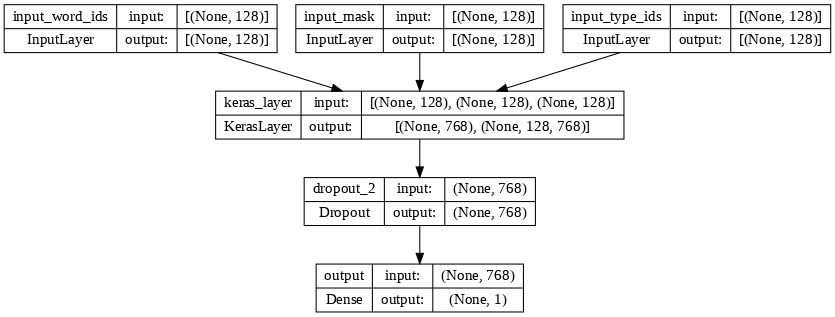

In [ ]:
tf.keras.utils.plot_model(model= model, show_shapes= True, dpi= 75)

In [ ]:
# Train model
epochs = 5
history = model.fit(train_data,
                    validation_data= valid_data,
                    epochs = epochs,
                    verbose= 1)

Epoch 1/5
306/306 [==============================] - 268s 821ms/step - loss: 0.1854 - binary_accuracy: 0.9319 - val_loss: 0.1098 - val_binary_accuracy: 0.9542
Epoch 2/5
306/306 [==============================] - 253s 824ms/step - loss: 0.0901 - binary_accuracy: 0.9650 - val_loss: 0.1237 - val_binary_accuracy: 0.9625
Epoch 3/5
306/306 [==============================] - 253s 824ms/step - loss: 0.0442 - binary_accuracy: 0.9848 - val_loss: 0.1391 - val_binary_accuracy: 0.9563
Epoch 4/5
306/306 [==============================] - 253s 823ms/step - loss: 0.0264 - binary_accuracy: 0.9922 - val_loss: 0.1543 - val_binary_accuracy: 0.9531
Epoch 5/5
306/306 [==============================] - 253s 824ms/step - loss: 0.0168 - binary_accuracy: 0.9951 - val_loss: 0.1764 - val_binary_accuracy: 0.9542


##Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

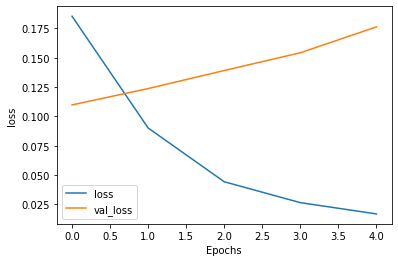

In [ ]:
plot_graphs(history, 'loss')

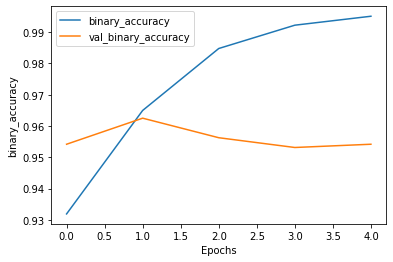

In [ ]:
plot_graphs(history, 'binary_accuracy')